In [1]:
!pip install perceval-quandela

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 29.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import perceval as pcvl
import perceval.components as comp

from perceval.components import PS, BS, PERM, Port
import numpy as np

from perceval.rendering.circuit import DisplayConfig, SymbSkin, PhysSkin
from perceval.utils import Encoding


In [3]:
delta1 = pcvl.Parameter("delta1")
xsi1 = pcvl.Parameter("xsi1")

delta2 = pcvl.Parameter("delta2")
xsi2 = pcvl.Parameter("xsi2")

delta3 = pcvl.Parameter("delta3")
xsi3 = pcvl.Parameter("xsi3")

phi1 = pcvl.Parameter("phi1")

In [4]:
mzi = (pcvl.Circuit(4)
       .add(1, comp.BS().H())

       .add(1, comp.WP(delta=delta1, xsi=xsi1)) # oracle marking
       .add(1, comp.WP(delta=delta1, xsi=xsi1)) # oracle marking

       .add(1, comp.BS().H())

       .add(0, comp.PBS())
       .add(2, comp.PBS())

       .add(1, comp.WP(delta=delta1, xsi=xsi1))
       .add(2, comp.WP(delta=delta1, xsi=xsi1))

       .add(1, comp.PS(np.pi))
       .add(2, comp.PS(np.pi))

       #.add(2, comp.WP(delta=delta1, xsi=xsi1))
       #.add(2, comp.WP(delta=delta2, xsi=xsi2))

       .add(1, comp.BS().H())

       .add(0, comp.PBS())
       .add(2, comp.PBS())

       .add(1, comp.WP(delta=delta1, xsi=xsi1))
       .add(2, comp.WP(delta=delta1, xsi=xsi1)))



In [13]:
mzi = (pcvl.Circuit(4) 
       .add(1, comp.BS().H())

       .add(1, comp.WP(delta=delta1, xsi=xsi1)) # h gate
       .add(2, comp.WP(delta=delta2, xsi=xsi2)) # x gate

       .add(1, comp.BS().H())

       .add(0, comp.PBS())
       .add(2, comp.PBS()))



In [6]:
mzi = (pcvl.Circuit(4)
      .add(1, comp.BS().H())
      #.add(2, comp.WP(delta=delta3, xsi=xsi3))
      #.add(2, comp.PS(phi=phi1))
      .add(2, comp.PR(delta=delta1))
      )

In [7]:
delta1.set_value(np.pi/2)
xsi1.set_value(np.pi/8)

delta2.set_value(np.pi/2)
xsi2.set_value(np.pi/4)

#xsi2.set_value(np.pi/4)

delta3.set_value(np.pi/2)
xsi3.set_value(0)

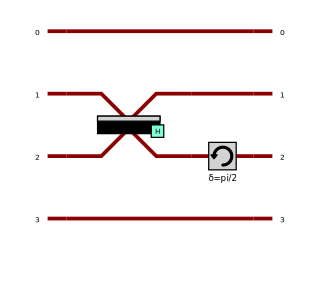

In [8]:
pcvl.pdisplay(mzi, skin=PhysSkin())


In [9]:
pcvl.pdisplay(mzi.U)

<IPython.core.display.Math object>

In [14]:
processor = pcvl.Processor("SLOS", mzi)
processor.add_port(0, Port(Encoding.DUAL_RAIL, 'port1'))
processor.add_port(2, Port(Encoding.DUAL_RAIL, 'port2'))

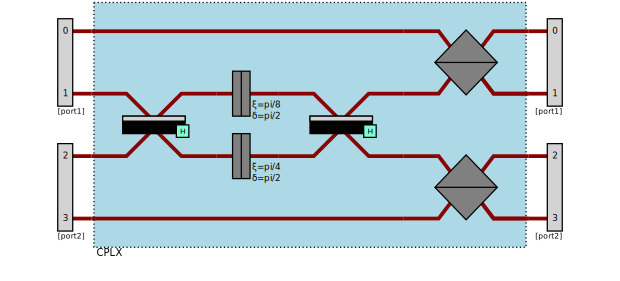

In [15]:
pcvl.pdisplay(processor, recursive=True)

In [16]:
input_state = pcvl.BasicState("|0,1,0,0>")
processor.with_input(input_state)
sampler = pcvl.algorithm.Sampler(processor)
sample_count = sampler.sample_count(10000)

In [17]:
print(sample_count['results'])

{
  |1,0,0,0>: 1235
  |0,1,0,0>: 7275
  |0,0,1,0>: 212
  |0,0,0,1>: 1278
}


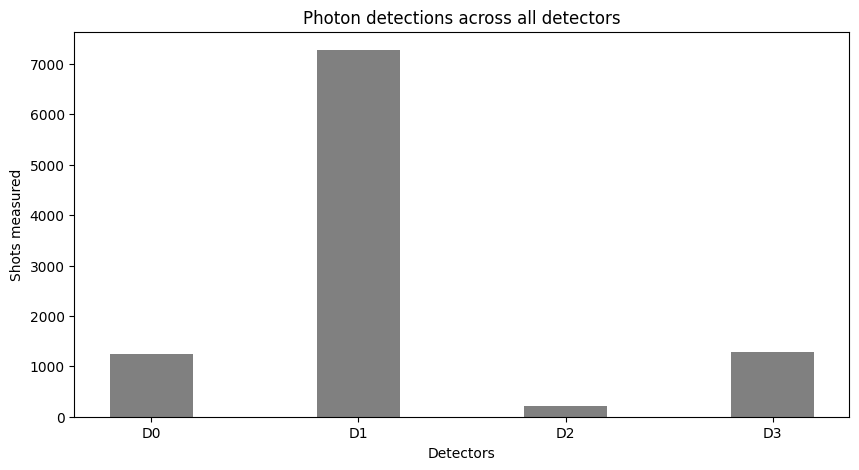

In [18]:
import matplotlib.pyplot as plt

detectors = ["D0", "D1", "D2", "D3"]
values = list(sample_count['results'].values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(detectors, values, color ='gray',
        width = 0.4)

plt.xlabel("Detectors")
plt.ylabel("Shots measured")
plt.title("Photon detections across all detectors")
plt.show()

In [19]:
from perceval.components import catalog
from perceval.components.source import Source
from perceval.algorithm import ProcessTomography
from perceval.algorithm.tomography import is_physical

In [20]:
#angles = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 5*np.pi/4, 3*np.pi/2, 7*np.pi/4, 2*np.pi]
devs = []
angles_to_test = np.linspace(0, 2*np.pi, 100)
#angles: list[list[float]] = []
for angle in angles_to_test:
  delta1.set_value(np.pi/2)
  xsi1.set_value(np.pi/8)

  delta2.set_value(np.pi/2)
  xsi2.set_value(angle)

  processor = pcvl.Processor("SLOS", mzi)
  processor.add_port(0, Port(Encoding.DUAL_RAIL, 'port1'))
  processor.add_port(2, Port(Encoding.DUAL_RAIL, 'port2'))

  input_state = pcvl.BasicState("|0,1,0,0>")
  processor.with_input(input_state)
  sampler = pcvl.algorithm.Sampler(processor)
  sample_count = sampler.sample_count(10000)

  print(sample_count['results'])

  vals = list(sample_count['results'].values())
  print(vals)
  deviation = 0
  # for v in vals:
  #   deviation += abs(2500 - v)
  # devs.append(deviation)
  if len(vals) == 4:
    for i in range(4):
      v = vals[i]
      if i == 0:
        deviation += abs(1275 - v)
      elif i == 1:
        deviation += abs(7250 - v)
      elif i == 2:
        deviation += abs(200 - v)
      else:
        deviation += abs(1275 - v)
    devs.append(deviation)

  if len(vals) == 3:
    for i in range(3):
      v = vals[i]
      if i == 0:
        deviation += abs(1275 - v)
      elif i == 1:
        deviation += abs(7250 - v)
      else:
        deviation += abs(200 - v)
    deviation += abs(1275 - 0)
    devs.append(deviation)

  if len(vals) == 2:
    for i in range(2):
      v = vals[i]
      if i == 0:
        deviation += abs(1275 - v)
      else:
        deviation += abs(7250 - v)
    deviation += abs(200 - 0)
    deviation += abs(1275 - 0)
    devs.append(deviation)
print(devs)



{
  |1,0,0,0>: 7272
  |0,1,0,0>: 1253
  |0,0,1,0>: 1261
  |0,0,0,1>: 214
}
[7272, 1253, 1261, 214]
{
  |1,0,0,0>: 7252
  |0,1,0,0>: 1722
  |0,0,1,0>: 808
  |0,0,0,1>: 218
}
[7252, 1722, 808, 218]
{
  |1,0,0,0>: 6992
  |0,1,0,0>: 2358
  |0,0,1,0>: 483
  |0,0,0,1>: 167
}
[6992, 2358, 483, 167]
{
  |1,0,0,0>: 6641
  |0,1,0,0>: 2933
  |0,0,1,0>: 290
  |0,0,0,1>: 136
}
[6641, 2933, 290, 136]
{
  |1,0,0,0>: 6248
  |0,1,0,0>: 3544
  |0,0,1,0>: 130
  |0,0,0,1>: 78
}
[6248, 3544, 130, 78]
{
  |1,0,0,0>: 5709
  |0,1,0,0>: 4238
  |0,0,1,0>: 35
  |0,0,0,1>: 18
}
[5709, 4238, 35, 18]
{
  |1,0,0,0>: 5141
  |0,1,0,0>: 4858
  |0,0,0,1>: 1
}
[5141, 4858, 1]
{
  |1,0,0,0>: 4503
  |0,1,0,0>: 5471
  |0,0,1,0>: 8
  |0,0,0,1>: 18
}
[4503, 5471, 8, 18]
{
  |1,0,0,0>: 3829
  |0,1,0,0>: 6056
  |0,0,1,0>: 35
  |0,0,0,1>: 80
}
[3829, 6056, 35, 80]
{
  |1,0,0,0>: 3161
  |0,1,0,0>: 6544
  |0,0,1,0>: 77
  |0,0,0,1>: 218
}
[3161, 6544, 77, 218]
{
  |1,0,0,0>: 2520
  |0,1,0,0>: 6887
  |0,0,1,0>: 161
  |0,0,0,1>: 432


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


100
100


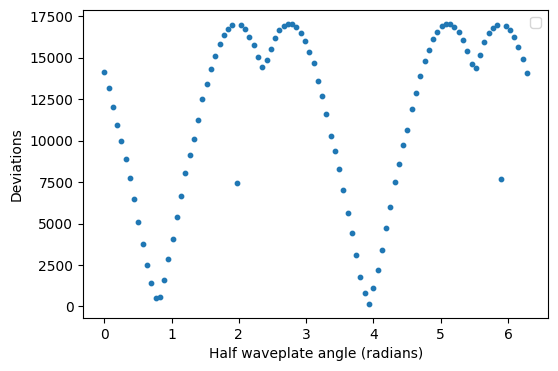

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

# Define data
#angles = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 5*np.pi/4, 3*np.pi/2, 7*np.pi/4, 2*np.pi]
#devs = [7044, 110, 7062, 60, 7152, 168, 7100, 108, 7004]

x = np.array(angles_to_test)
y = np.array(devs)

def test_func(x, a, b, c):
    return a * np.sin(b * x) + c

# Initial guess for the parameters: [amplitude, frequency, offset]
initial_guess = [3600, 1, 3600]

# Fit the curve
# params, params_covariance = optimize.curve_fit(test_func, x, y, p0=initial_guess)
# print("Fitted parameters:", params)

print(len(x))
print(len(y))

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(x, y, s=10)
#plt.plot(x, test_func(x, *params), label='Fitted function', color='red')

# Adding labels and title
plt.xlabel('Half waveplate angle (radians)')
plt.ylabel('Deviations')
#plt.title('Half waveplate angle deviations from expected photon counts')
plt.legend(loc='best')

plt.show()


In [22]:
!pip install qiskit


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [23]:
pip install pylatexenc

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136814 sha256=fbf4129e2f8add90e45e31c2a3b733cf0f2b165316a7f9ef2b0fd8dd8786bda9
  Stored in directory: /Users/neha/Library/Caches/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [24]:
from qiskit import QuantumCircuit, transpile
from qiskit.providers.fake_provider import GenericBackendV2

In [25]:
!pip install qiskit_aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.1 MB/s eta 0:00:00
  Attempting uninstall: rustworkx
    Found existing installation: rustworkx 0.14.1
    Uninstalling rustworkx-0.14.1:
      Successfully uninstalled rustworkx-0.14.1
  Attempting uninstall: qiskit
    Found existing installation: qiskit 1.0.1
    Uninstalling qiskit-1.0.1:
      Successfully uninstalled qiskit-1.0.1

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [26]:
from qiskit_aer import AerSimulator

ImportError: cannot import name 'Store' from 'qiskit.circuit' (/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qiskit/circuit/__init__.py)

In [27]:
qc = QuantumCircuit(2)
# qc.h(0)
# qc.h(1)
# #qc.cz(0,1)

# qc.h(0)
# qc.h(1)

# qc.z(0)
# qc.z(1)

# qc.cz(0,1)

# qc.h(0)
# qc.h(1)

qc.x(1)
qc.save_statevector()

AttributeError: 'QuantumCircuit' object has no attribute 'save_statevector'

In [28]:
qc_aer = transpile(qc, backend=AerSimulator())
simulator_aer = AerSimulator()
results = simulator_aer.run(qc_aer, shots=1024).result()
counts=results.get_counts()

NameError: name 'AerSimulator' is not defined

In [29]:
counts

NameError: name 'counts' is not defined